<a href="https://colab.research.google.com/github/LordMordo/ieee_fraud_detection/blob/master/ieee_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install kaggle --upgrade

     |████████████████████████████████| 61kB 3.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=302b4007776def68d9aa8ac4b2c7b6d182d5d199b76a2bef01f50405f276c81e
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.5
    Uninstalling kaggle-1.5.5:
      Successfully uninstalled kaggle-1.5.5


In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beardboss","key":"77f3f441234690678a6080a04f4b4057"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# import dataset
!kaggle competitions download -c ieee-fraud-detection


 93% 49.0M/52.5M [00:01<00:00, 32.6MB/s]
100% 52.5M/52.5M [00:01<00:00, 47.2MB/s]
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 99.0MB/s]
 87% 41.0M/47.3M [00:00<00:00, 36.7MB/s]
100% 47.3M/47.3M [00:00<00:00, 60.8MB/s]
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 97.6MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 160MB/s]


In [45]:
!unzip train_identity.csv.zip
!unzip train_transaction.csv.zip
!unzip test_identity.csv.zip
!unzip test_transaction.csv.zip
!unzip sample_submission.csv.zip

Archive:  train_identity.csv.zip
replace train_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  train_transaction.csv.zip
replace train_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  test_identity.csv.zip
replace test_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  test_transaction.csv.zip
replace test_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [0]:
# This Step is done to reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

In [19]:
train_trans = pd.read_csv('./train_transaction.csv')
train_iden = pd.read_csv('./train_identity.csv')
test_trans = pd.read_csv('./test_transaction.csv')
test_iden = pd.read_csv('./test_identity.csv')
print(f'train transaction shape: {train_trans.shape} train identity shape: { train_iden.shape}')
print(f'test transaction shape: {test_trans.shape} test identity shape: {test_iden.shape}')

train transaction shape: (590540, 394) train identity shape: (144233, 41)
test transaction shape: (506691, 393) test identity shape: (141907, 41)


In [0]:
# left-join transaction and identity on TransactionID
train_df=pd.merge(train_trans,train_iden,how="left",on="TransactionID")
test_df=pd.merge(test_trans,test_iden,how="left",on="TransactionID")

In [0]:
train_df.head()

In [24]:
train_df=reduce_mem_usage(train_df)
test_df=reduce_mem_usage(test_df)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [0]:
# delete the 4 variables in order to reduce the memory issue
del train_iden
del train_trans
del test_trans
del test_iden

In [26]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TransactionID,590540.0,3.282270e+06,1.704744e+05,2.987000e+06,3.134635e+06,3282269.50,3429904.25,3577539.0
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000000e+00,0.000000e+00,0.00,0.00,1.0
TransactionDT,590540.0,7.372311e+06,4.617224e+06,8.640000e+04,3.027058e+06,7306527.50,11246620.00,15811131.0
TransactionAmt,590540.0,NaN,NaN,2.509766e-01,4.331250e+01,68.75,125.00,31936.0
card1,590540.0,9.898735e+03,4.901170e+03,1.000000e+03,6.019000e+03,9678.00,14184.00,18396.0
card2,581607.0,NaN,NaN,1.000000e+02,2.140000e+02,361.00,512.00,600.0
card3,588975.0,NaN,0.000000e+00,1.000000e+02,1.500000e+02,150.00,150.00,231.0
card5,586281.0,NaN,0.000000e+00,1.000000e+02,1.660000e+02,226.00,226.00,237.0
addr1,524834.0,NaN,NaN,1.000000e+02,2.040000e+02,299.00,330.00,540.0
addr2,524834.0,NaN,0.000000e+00,1.000000e+01,8.700000e+01,87.00,87.00,102.0


In [27]:
#categorical columns
cat_cols = [col for col in train_df.columns if train_df[col].dtype in ['object']]
train_df[cat_cols].describe()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,590540,588963,588969,496084,137291,319440,319440,319440,309096,240058,421180,244275,244288,244288,144233,140985,129340,5169,5169,140978,140978,77565,140282,73289,77805,140985,140985,140985,140985,140810,118666
unique,5,4,4,59,60,2,2,2,3,2,2,2,2,2,2,3,2,3,2,2,2,75,130,260,4,2,2,2,2,2,1786
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,F,F,F,T,NotFound,Found,Found,IP_PROXY:TRANSPARENT,Found,Found,Found,Windows 10,chrome 63.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
freq,439670,384767,439938,228355,57147,319415,285468,251731,196405,132491,227856,211374,155251,205656,123025,67728,66324,3489,5155,76232,74926,21155,22000,16874,60011,77814,134066,110452,73922,85165,47722


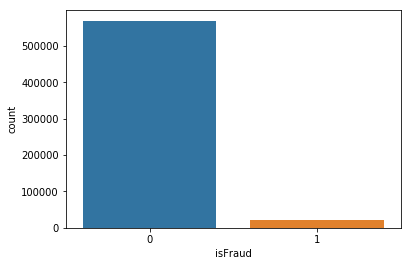

In [18]:
#visualizing "isFraud"
sns.countplot(x='isFraud', data=train_trans)

In [28]:
# Check missing data
def missing_data(df) :
    count = df.isnull().sum()
    percent = (df.isnull().sum()) / (df.isnull().count()) * 100
    total = pd.concat([count, percent], axis=1, keys = ['Count', 'Percent'])
    types = []
    for col in df.columns :
        dtypes = str(df[col].dtype)
        types.append(dtypes)
    total['dtypes'] = types
    
    return np.transpose(total)

missing_data(train_df)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Count,0,0,0,0,0,0,8933,1565,1577,4259,1571,65706,65706,352271,552913,94456,453249,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1269,280797,262878,168922,309841,517353,551623,515614,515614,...,446307,449668,524216,524216,453675,453675,585385,585385,515614,515614,449562,446307,463220,510496,449555,461200,451171,545427,451222,451279,585381,585371,585371,585793,585408,585377,585371,449562,449562,512975,450258,512954,517251,512735,449555,449555,449555,449555,449730,471874
Percent,0,0,0,0,0,0,1.51268,0.265012,0.267044,0.721204,0.266028,11.1264,11.1264,59.6524,93.6284,15.9949,76.7516,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.214888,47.5492,44.5149,28.6047,52.4674,87.6068,93.4099,87.3123,87.3123,...,75.5761,76.1452,88.7689,88.7689,76.8238,76.8238,99.1271,99.1271,87.3123,87.3123,76.1273,75.5761,78.4401,86.4456,76.1261,78.098,76.3997,92.3607,76.4084,76.418,99.1264,99.1247,99.1247,99.1962,99.131,99.1257,99.1247,76.1273,76.1273,86.8654,76.2451,86.8619,87.5895,86.8248,76.1261,76.1261,76.1261,76.1261,76.1557,79.9055
dtypes,int32,int8,int32,float16,object,int16,float16,float16,object,float16,object,float16,float16,float16,float16,object,object,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,...,float16,float32,float16,float16,float16,float16,float16,float16,float16,float16,float16,object,float16,float16,object,object,float16,float16,float16,float16,float16,float16,object,float16,float16,float16,object,object,object,object,object,float16,object,object,object,object,object,object,object,object


In [0]:
# dropping cols > 60% missing values
null_percent = train_df.isnull().sum()/train_df.shape[0]*100

cols_to_drop = np.array(null_percent[null_percent > 60].index)

In [35]:
cols_to_drop.shape

(208,)

In [0]:
# Drop Columns from data
train_df = train_df.drop(cols_to_drop, axis=1)
test_df = test_df.drop(cols_to_drop,axis=1)

In [37]:
print(train_df.shape)
print(test_df.shape)

(590540, 226)
(506691, 225)


In [0]:
# filling missing Values with substitute

train_df = train_df.fillna(-999)
test_df = test_df.fillna(-999)

In [0]:
# setting up train data
train_y = train_df['isFraud']
train_X = train_df.drop('isFraud', axis=1)

In [0]:
# Label Encoding for categorical variables.
for f in train_X.columns:
    if train_X[f].dtype=='object' or test_df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_X[f].values) + list(test_df[f].values))
        train_X[f] = lbl.transform(list(train_X[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

In [43]:
# LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_X, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
submission = pd.read_csv('./sample_submission.csv',index_col='TransactionID')
submission['isFraud'] = logreg.predict_proba(test_df)[:,1]
submission.to_csv('Logreg_submission.csv')
submission.head()

,isFraud
TransactionID,
3663549,0.025645
3663550,0.029313
3663551,0.034949
3663552,0.030018
3663553,0.026783
